In [37]:
# Dimitrios Bakalis

from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import glob
import cv2
import cv2
import os

In [38]:
yes_list = []
for filename in glob.glob(r'C:\Users\Dimitris\Desktop\project\yes\*.jpg'): 
    image = Image.open(filename).convert('RGB')    # loading an RGB image (.jpg)
    resized_image = image.resize((400, 400))       # resizing the image to 400 x 400
    yes_list.append(resized_image)                 # saving the image to a list 

no_list = []
for filename in glob.glob(r'C:\Users\Dimitris\Desktop\project\no\*.jpg'): 
    image = Image.open(filename).convert('RGB')
    resized_image = image.resize((400, 400))
    no_list.append(resized_image)

Brain image with visible tumor (Class:1)


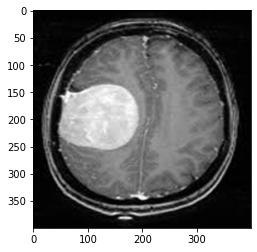

In [75]:
plt.imshow(yes_list[0], cmap='gray')
print ("Brain image with visible tumor (Class:1)")

Brain image with no tumor (Class:0)


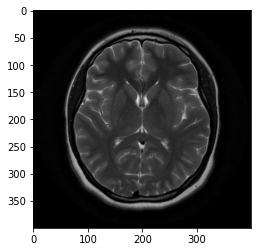

In [76]:
plt.imshow(no_list[0], cmap='gray')
print ("Brain image with no tumor (Class:0)")

In [41]:
np_yes_list = []
yes_labels_list = []

for image in yes_list:
    np_img = np.array(image)
    np_yes_list.append(np_img)
    yes_labels_list.append(1)

np_no_list = []
no_labels_list = []

for image in no_list:
    np_img = np.array(image)
    np_no_list.append(np_img)
    no_labels_list.append(0)

np_no_list.extend(np_yes_list)            # combining the two data lists into one
data = np_no_list
data = np.array(data)                     # converting the list to a numpy array

no_labels_list.extend(yes_labels_list)    # combining the two label lists into one
labels = no_labels_list   
labels = np.array(labels)                 # converting the list to a numpy array

print("data shape",data.shape)
print("labels shape",labels.shape)

data shape (249, 400, 400, 3)
labels shape (249,)


In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3,random_state=109) # 70% of our data for training and the rest 30% for testing/validation

print("train data",X_train.shape)

train data (174, 400, 400, 3)


In [43]:
X_val, X_real_train, y_val, y_real_train = train_test_split(X_test, y_test, test_size=0.3,random_state=109) # 70% of our data for validation and the rest 30% for testing

print("validation data",X_val.shape)
print("test data",X_real_train.shape)

validation data (52, 400, 400, 3)
test data (23, 400, 400, 3)


In [44]:
model = tf.keras.models.Sequential([    tf.keras.layers.Conv2D(20,(3,3), activation = 'relu', input_shape = (400,400,3)),   # image shape 400 x 400 x 3(RGB Channel)
                                        tf.keras.layers.MaxPool2D(2,2),
                                        #
                                        tf.keras.layers.Conv2D(40,(3,3), activation = 'relu'),
                                        tf.keras.layers.MaxPool2D(2,2),
                                        #
                                        tf.keras.layers.Conv2D(60,(3,3), activation = 'relu'),
                                        tf.keras.layers.MaxPool2D(2,2),
                                        ##
                                        tf.keras.layers.Flatten(),
                                        ##
                                        tf.keras.layers.Dense(512, activation = 'relu'),
                                        ##
                                        tf.keras.layers.Dense(1, activation = 'sigmoid')     # binary classification --> sigmoid activation
                                        ])

In [45]:
model.compile(  loss = 'binary_crossentropy', 
                optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001), 
                metrics = ['accuracy'])

In [46]:
model_fit =  model.fit( X_train,
                        y_train,
                        steps_per_epoch = 3,
                        epochs = 15,
                        validation_data=(X_val, y_val))

Epoch 1/15
3/3 [==============================] - 11s 4s/step - loss: 3869.2605 - accuracy: 0.5690 - val_loss: 1446.0665 - val_accuracy: 0.4038
Epoch 2/15
3/3 [==============================] - 10s 3s/step - loss: 563.5159 - accuracy: 0.6437 - val_loss: 78.1488 - val_accuracy: 0.6538
Epoch 3/15
3/3 [==============================] - 10s 3s/step - loss: 53.7551 - accuracy: 0.6379 - val_loss: 37.0195 - val_accuracy: 0.7692
Epoch 4/15
3/3 [==============================] - 10s 3s/step - loss: 12.2090 - accuracy: 0.8391 - val_loss: 17.2922 - val_accuracy: 0.6731
Epoch 5/15
3/3 [==============================] - 10s 3s/step - loss: 5.5852 - accuracy: 0.8908 - val_loss: 9.1214 - val_accuracy: 0.7308
Epoch 6/15
3/3 [==============================] - 10s 3s/step - loss: 0.8768 - accuracy: 0.9195 - val_loss: 8.2966 - val_accuracy: 0.8269
Epoch 7/15
3/3 [==============================] - 10s 3s/step - loss: 0.0352 - accuracy: 0.9885 - val_loss: 6.6583 - val_accuracy: 0.7308
Epoch 8/15
3/3 [=====

[[ 6  2]
 [ 2 13]]
Test Accuracy 0.8260869565217391


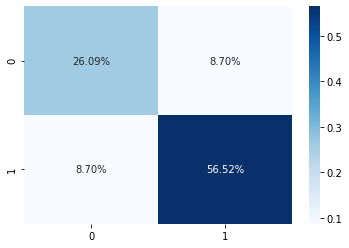

In [74]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns

pred = (model.predict(X_real_train) > 0.5).astype("int32")

mat = confusion_matrix(y_real_train,pred)
print(mat)

sns.heatmap(mat/np.sum(mat), annot=True, 
            fmt='.2%', cmap='Blues')

acc = accuracy_score(y_real_train, pred)
print("Test Accuracy", acc)

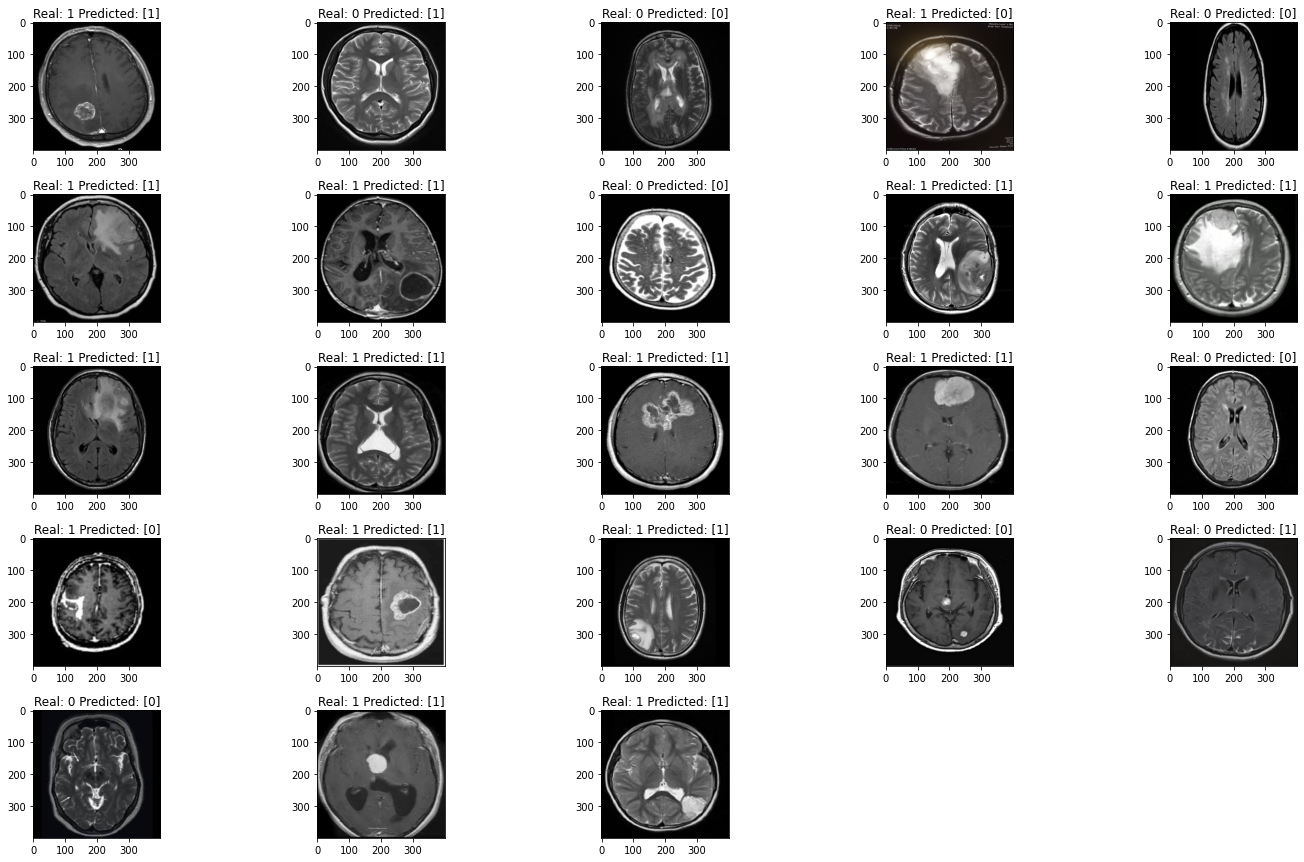

In [73]:
fig = plt.figure(figsize=(25,15))
fig.subplots_adjust(hspace=0.35, wspace=0.1)

i=-1
for image in X_real_train:
    i+=1
    ax = fig.add_subplot(5, 5, i+1)
    plt.imshow(image, cmap='gray')
    title = "Real: " + str(y_real_train[i]) + " Predicted: " + str(pred[i])
    plt.title(title)

plt.show()